# California Housing Prices Prediction
###  Prediction of district's median house price
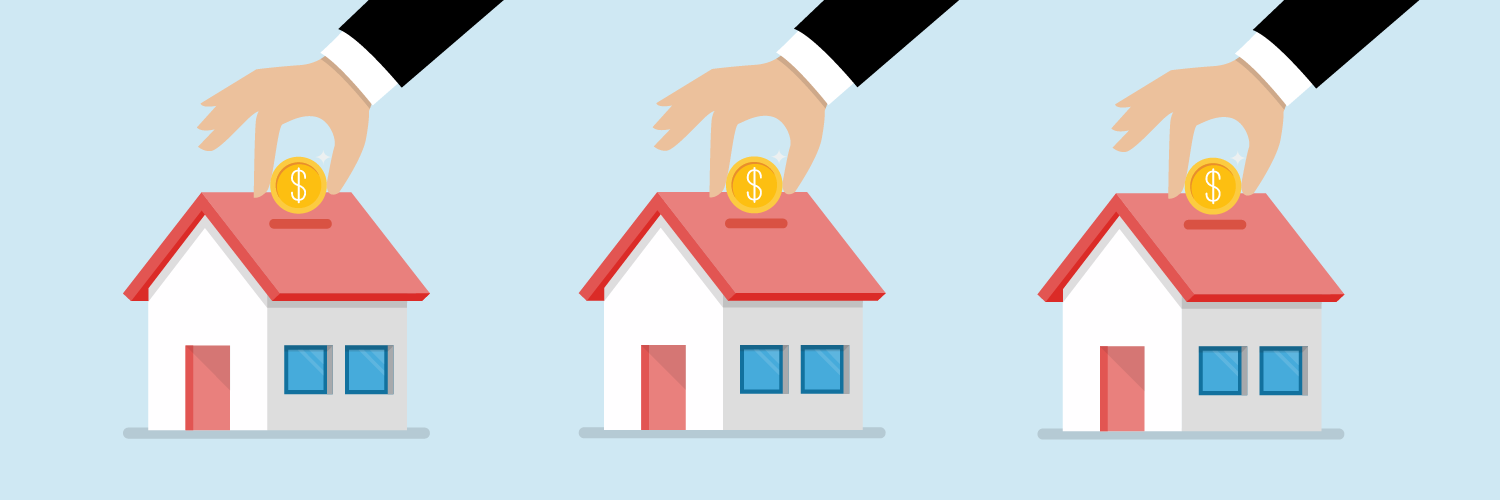

### Feature Reference
- **longitude:** A measure of how far west a house is; a higher value is farther west
- **latitude:** A measure of how far north a house is; a higher value is farther north
- **housingMedianAge:** Median age of a house within a block; a lower number is a newer building
- **totalRooms:** Total number of rooms within a block
- **totalBedrooms:** Total number of bedrooms within a block
- **population:** Total number of people residing within a block
- **households:** Total number of households, a group of people residing within a home unit, for a block
- **medianIncome:** Median income for households within a block of houses (measured in tens of thousands of US Dollars)
- **medianHouseValue:** Median house value for households within a block (measured in US Dollars)
- **oceanProximity:** Location of the house w.r.t ocean/sea

## Read the Data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### What exactly is the business objective?
Before we go about exploring the data, it is always important to state what the goal of the analysis is.
- To predict the **median house prices** in the state of California

### Frame the problem
- **Supervised Learning Task** - This is a superised learning task because we are given labels (median house value) for the training set
- **Regression Task** - The target(median house value) is a continous value
- **Multiple Regression** - We will be using multiple features to make the prediction
- **Univariate Regression** - We will be predicting only a single value(median housing value) for each district
- **Batch Learning** - Since there is no continous flow of data and the data is small enough to fit in the memory, we do batch or offline learning

### Select the perfomance measure
- A typical performance measure for regression problems is **RMSE**. RMSE corresponds to l2 norm and so is more sensitive to outliers so if there are many outlier districts **MAE** (corresponds to l1 norm) may be a better performance measure

In [ ]:
california_housing_DF = pd.read_csv("/kaggle/input/california-housing-prices/housing.csv")
california_housing_DF.head()

In [ ]:
california_housing_DF.info()

> 📊 **My insight**
> * The dataset consists of 20640 instances. This is a small dataset by Machine Learning standards.
> * The attribute **total_bedrooms** has only 20433 instances meaning there are few values that are missing 
> * There is 1 categorical features - **ocean_proximity**
> * There are 7 numeric features - **longitude, latitude, housing_median_age, total_rooms,total_bedrooms, population, households, median_income, median_house_value, ocean_proximity**

In [ ]:
california_housing_DF.describe()

> 📊 **My insight**
> * It is important to note that **describe()** ignores null values
> * **Standard Deviation** measures how dispered the values are.
> * **Percentile** indicates the value below which a percentage of the datapoints fall. Example, 25% of the districts have houses that are 18 years old or lesser


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
california_housing_DF.hist(bins=50, figsize = (20, 15))
plt.show()

> 📊 **My insight**
> * The median **age** of a houses within blocks(districts) is between 1 and 52. From the histogram we see there are a lot of houses aged 52.The number of houses aged 52 are unusally higher than the other counts. This is because the age value was capped. Any house that was older than 52 years was considered 52 years.
> * Similarly **median house value** is also capped at 500,001 dollars. This maybe a serious problem because this is the target variable. The ML model may not learn to predict house values beyond 500,001 dollars
> * The max and min value for **median income** is 1 and 15. From feature reference we understand that 1 actually means 10,000 dollars
> * Notice how attributes all have different scales. We need to perform **feature scaling** to fix this.
> * Finally, we notice that attributes like **total_rooms, total_bedrooms, households** tend to be tail heavy: they extend much farther to the right.This may mean that that the attributes have a lot of outliers. For example, we see 75% of the blocks have a total of 3148 rooms or less. We see there is one block that has a total of 39320 rooms. Having outliers will make it difficult for the Machine Learning model to detect patterns. We will transform them later to more bell-shaped attributes.


### Create train and test set
- To avoid **Data Snooping** lets keep the test set aside before doing any exploratory data analysis.
- If your dataset is large enough **Random Sampling method** would suffice but if not you run the risk of introducing **sampling bias**.
- **Stratified sampling** is when you divide the population into homogeneous subgroups calles *strata* and you include the right number of instances from each *stratum* into the test set.
- Let's do stratified sampling based on median income.

In [ ]:
california_housing_DF["income_category"] = pd.cut(california_housing_DF["median_income"], bins= [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1,2,3,4,5])
california_housing_DF['income_category'].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size =0.2, random_state = 42)
for train_idx, test_idx in sss.split(california_housing_DF,california_housing_DF['income_category']):
    train_set = california_housing_DF.loc[train_idx]
    test_set =  california_housing_DF.loc[test_idx]

# proportion of income category in full set 
print("Proportion of income category in full set")
print("------------------------------------------")
print(california_housing_DF['income_category'].value_counts()/len(california_housing_DF))

# proportion of income category in test set
print("\n Proportion of income category in test set")
print("------------------------------------------")
print(test_set['income_category'].value_counts()/len(test_set))

# proportion of income category in train set
print("\n Proportion of income category in train set")
print("------------------------------------------")
print(train_set['income_category'].value_counts()/len(train_set))

for set_ in (train_set, test_set):
    set_.drop("income_category", axis = 1, inplace = True)

### Exploratory Data Analysis
- When doing EDA, create a copy of the training set so you can play with it without harming it 

#### 1. Visualize Geographical data
- Let's do a scatterplot to visualize the districts in California

In [ ]:
housing = train_set.copy()

In [ ]:
# s - radius of each circle represents district population
# c - color represents price
# alpha - visualize places with high density
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(housing[['median_house_value', 'median_income', 'total_rooms','housing_median_age']], figsize=(12,8))

> 📊 **My insight**
> * The houses close to the ocean are more expensive. Also, housing prices is related to population density.
> * The correlation between **median_income** and **median_house_value** is very strong and it looks like they are positively correlated.
> * The scatter plots of other attributes seem to be more dispersed. Let's try combining the attributes to see if they give us a better correlation

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]


corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
print(corr_matrix["total_bedrooms"].sort_values(ascending=False))

> 📊 **My insight**
> * **Bedrooms per room** is negatively correlated to **median house value**. Houses with lower bedrooms to room ratio tend to be more expensive. Interesting!
> * Also, **rooms per household** attribute tends to be more informative than **total_rooms**
> * **total bedrooms** is positively correlated with **households, total_rooms and population**.Would we need all 4 features?

### Preparing the data for machine learning
- Let' start by seperating thr predictors and labels. Since we don't want to apply the same transformation to the predictors and target.

#### Data Cleaning
- Let's fill in the missing values in **total_bedrooms**. For that we use scikitlearn's SimpleImputer. It computes the median of each attribute and stores it in **statistics_** instance.We fit the imputer on the train set and transform the train and test set.**Note:** We don't fit the imputer again on the test set.
- Let's also add the 3 additional combined attributes that we discovered in the EDA part had more correlation to the target variable.
- Next, we perform **feature scaling** using scikitlearn's StandarScalar to ensure every attribute has the same scale.We fit the standard scale on the train set and transform the train and test set.**Note:** We don't fit it again on the test set.
- Finally we perform **one hot encoding** on the single categorical feature **ocean_proximity** and then combine all the features together. After this, we are ready to select and train a model!

In [ ]:
housing_features = train_set.drop("median_house_value", axis=1)
housing_labels = train_set['median_house_value'].copy()

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [ ]:
housing_f_numeric = housing_features.drop("ocean_proximity",axis=1)
imputer.fit(housing_f_numeric)

In [ ]:
print(imputer.statistics_)
X = imputer.transform(housing_f_numeric)
X_train_numeric = pd.DataFrame(X, columns = housing_f_numeric.columns, index = housing_f_numeric.index)

In [ ]:
X_train_numeric["rooms_per_household"] = X_train_numeric["total_rooms"]/X_train_numeric["households"]
X_train_numeric["bedrooms_per_room"] = X_train_numeric["total_bedrooms"]/X_train_numeric["total_rooms"]
X_train_numeric["population_per_household"]= X_train_numeric["population"]/X_train_numeric["households"]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_numeric)
print(scaler.mean_)
X = scaler.transform(X_train_numeric)
X_train_numeric_scaled = pd.DataFrame(X, columns = X_train_numeric.columns, index = X_train_numeric.index)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
X_train_category = pd.DataFrame(cat_encoder.fit_transform(housing_features[['ocean_proximity']]).toarray(), columns = cat_encoder.categories_,index = housing_features.index)

In [ ]:
X_train_category

In [ ]:
X_train = pd.concat([X_train_numeric_scaled, X_train_category], axis=1, sort=False)
X_train.head()

### Select and train a model
- Let's try the following models:

    - **Linear Regression**
    - **Decision Tree Regressor**
    - **Random Forest Regressor**
    - **Support Vector Machine**
- Let's also do the evaluation using cross-validation. This way we can test our models on multiple validation sets

In [ ]:
y_train = housing_labels
from sklearn.model_selection import cross_val_score

In [ ]:
def print_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring = "neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print_scores(lin_rmse_scores)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring = "neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
print_scores(tree_rmse_scores)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(X_train, y_train)
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring = "neg_mean_squared_error",cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print_scores(forest_rmse_scores)

In [ ]:
from sklearn import svm
svm_reg = svm.SVR()
svm_reg.fit(X_train, y_train)
svm_scores = cross_val_score(svm_reg, X_train, y_train, scoring = "neg_mean_squared_error",cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
print_scores(svm_rmse_scores)

> 📊 **My insight**
> * Out of all the models tested, the SVM model produced the worst results.The Decision Tree model peformed worse than Linear Regression.
> * Random Forest looks the most promising model so let's try to fine tune the model by performing Hyperparameter Tuning.

### Fine tune your model
#### Grid Search
- When you have no idea what values to use for hyperparameter tuning, you can try out consecutive powers of 10 (1,10,100,1000,.....)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators':[1000],
     'max_features': [2,4,6,8,10]},
    {'bootstrap':[False],
     'n_estimators':[3,10],
     'max_features': [2,3,4]}
]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],cvres['params']):
    print(np.sqrt(-mean_score), params)

> 📊 My insight
> * The RMSE score for the tuned RandomForest is better than the score we got using the default hyperparameter values. We now have a fined tuned best model!
> * Before we move on, let's also try to implement Randomized Search.

In [ ]:
grid_search.best_estimator_

#### Randomized Search
- When the hyperparameter space is large, it is prefereable to use RandomSearchCV instead on GridSearch CV. 
- Unlike GridSeach that evaluates all combination of hyperparameter values, this evaluates random combinations of values at each iteration. If you let the randomized search run for 1000 iterarions, it evaluates 1000 different value combinations.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = [
    {'n_estimators':[3,10,30],
     'max_features': [2,4,6,8,10]},
    {'bootstrap':[False],
     'n_estimators':[3,10],
     'max_features': [2,3,4]}
]
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(X_train, y_train)

In [ ]:
rnd_search.best_params_

### Evaluate your model on the test set
- Since we did not automate the cleaning and transformation step, we need to do it once more to the testing set in order for us to pass the testing set into the ML model for prediction.
- You should use the trained Imputer and Standard Scaler to transform the test set.

In [ ]:
housing_X_test = test_set.drop("median_house_value", axis = 1)
y_test = test_set['median_house_value'].copy()

In [ ]:
housing_test_numeric = housing_X_test.drop("ocean_proximity",axis=1)
X = imputer.transform(housing_test_numeric)
X_test_numeric = pd.DataFrame(X, columns = housing_test_numeric.columns, index = housing_test_numeric.index)

In [ ]:
X_test_numeric["rooms_per_household"] = X_test_numeric["total_rooms"]/X_test_numeric["households"]
X_test_numeric["bedrooms_per_room"] = X_test_numeric["total_bedrooms"]/X_test_numeric["total_rooms"]
X_test_numeric["population_per_household"]= X_test_numeric["population"]/X_test_numeric["households"]

In [ ]:
X_test_numeric.head()

In [ ]:
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(X_test_numeric)
print(scaler.mean_)
X = scaler.transform(X_test_numeric)
X_test_numeric_scaled = pd.DataFrame(X, columns = X_test_numeric.columns, index = X_test_numeric.index)

In [ ]:
cat_encoder = OneHotEncoder()
X_test_category = pd.DataFrame(cat_encoder.fit_transform(housing_X_test[['ocean_proximity']]).toarray(), columns = cat_encoder.categories_,index = housing_X_test.index)

In [ ]:
X_test = pd.concat([X_test_numeric_scaled, X_test_category], axis=1, sort=False)
X_test.head()

In [ ]:
from sklearn.metrics import mean_squared_error
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

In [ ]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

- We have a 95% confidence interval that the generalization error will fall between 44833.57672874, 48674.0419568